In [156]:
# Importing packages
import cx_Oracle
import pandas as pd
from datetime import timedelta
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

In [157]:
# Variable declaration
a = timedelta(seconds=300)

# Show all rows
pd.set_option('display.max_rows', None)

In [158]:
# Importing data from Oracle database
con = cx_Oracle.connect('STC_SETRAG/art@localhost/XE')
cur = con.cursor()

# First Query
query=cur.execute('select * from historico_mensagens')
df = pd.DataFrame(query)
# Second Query
query=cur.execute('select EV_NOM_MAC from ELEM_VIA where TE_ID_TP = 3')
df_sb = pd.DataFrame(query)

cur.close()
con.close()

In [159]:
# Formatting dataframe

# Adding names to the columns of the dataframes
df.columns=['HM_ID_HM','HM_LOCO_MSG','HM_PRF_TRM','HM_OBC_MSG','HM_NUM_MSG','HM_TP_MSG','HM_DAT_OBC','HM_DAT_STC',
            'HM_TXT_MSG','HM_TXT_TW','HM_LAT_HM','HM_LON_HM','HM_ENV_RCB','HM_MSG_VOZ','HM_NUM_FUN','HM_ID_AUX','HM_SIT_ENV','MT_ID_MT']
df_sb.columns=['NAME']
# Dropping tables with no use
df = df.drop(['HM_TP_MSG','HM_TXT_TW','MT_ID_MT','HM_ID_AUX','HM_OBC_MSG','HM_LAT_HM','HM_LON_HM'], axis=1)

In [160]:
# Splitting dataframe in 'Sent' and 'Received' messages
df_sent = df.loc[df['HM_ENV_RCB']=='E']
df_received = df.loc[df['HM_ENV_RCB']=='R']

# Removing the original dataframe
df = pd.DataFrame(None)

In [161]:
# Filter Part I 

# Sent DataFrame
# 1) Filter messages from november 2020
df_sent = df_sent.loc[df_sent['HM_DAT_STC']>'2020-11-01']
# 2) Filter all messages that contain OBC time
df_sent = df_sent.loc[df_sent['HM_DAT_OBC'].notnull()]

# Received DataFrame
# 1) Filter all messages that did not expired
df_received = df_received.loc[df_received['HM_SIT_ENV']=='E']
# 2) Filter messages from november 2020
df_received = df_received.loc[df_received['HM_DAT_STC']>'2020-11-01']
# 3) Filter all messages that contain OBC time
df_received = df_received.loc[df_received['HM_DAT_OBC'].notnull()]
# 4) Filter all messages that have a date later than needed
df_received = df_received.loc[df_received['HM_DAT_OBC']<'2020-12-01']

In [162]:
# Returns amount of messages after the first filtering
df_sent.shape, df_received.shape

((54017, 11), (76358, 11))

In [163]:
# Storing the total of messages in a variable after first filtering for both Sent and Received messages

# Sent
totalSentMessages = len(df_sent['HM_ID_HM'])

# Received
totalReceivedMessages = len(df_received['HM_ID_HM'])

totalSentMessages, totalReceivedMessages

(54017, 76358)

In [164]:
# Return the average delivery time of Sent and Received messages

# Sent
df_sent['DELIVERY_TIME'] = df_sent['HM_DAT_OBC']-df_sent['HM_DAT_STC']
# Converting to string in order to execute a mathematic operation
df_sent['DELIVERY_TIME'] = df_sent['DELIVERY_TIME']/np.timedelta64(1, 's')
totalSent = sum(df_sent.iloc[:,11])
averageSentDelivery = round(totalSent/totalSentMessages,0)
# Converting from float to mm:ss
averageSentDelivery = timedelta(seconds=averageSentDelivery)
averageSentDelivery=str(averageSentDelivery)

# Received
df_received['DELIVERY_TIME'] = df_received['HM_DAT_STC']-df_received['HM_DAT_OBC']
# Converting to string in order to execute a mathematic operation
df_received['DELIVERY_TIME'] = df_received['DELIVERY_TIME']/np.timedelta64(1, 's')
totalReceived = sum(df_received.iloc[:,11])
averageReceivedDelivery = round(totalReceived/totalReceivedMessages,0)
# Converting from float to mm:ss
averageReceivedDelivery = timedelta(seconds=averageReceivedDelivery)
averageReceivedDelivery = str(averageReceivedDelivery)

averageSentDelivery, averageReceivedDelivery

('0:02:58', '0:00:49')

In [165]:
# Return the average delivery time of Sent and Received messages combined
averageDelivery = round((totalSent + totalReceived)/(totalSentMessages + totalReceivedMessages),0)
# Converting from float to mm:ss
averageDelivery = timedelta(seconds=averageDelivery)
averageDelivery = str(averageDelivery)

averageDelivery

'0:01:42'

D:\anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
D:\anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


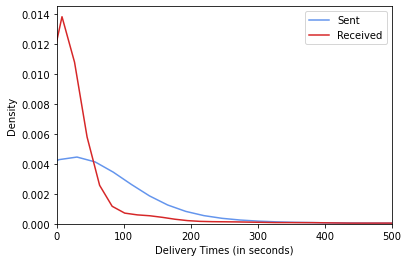

In [166]:
# Density graph
sns.distplot(df_sent['DELIVERY_TIME'],hist=False,kde=True,color = 'cornflowerblue', label = 'Sent')
sns.distplot(df_received['DELIVERY_TIME'],hist=False,kde=True, color = 'tab:red', label = 'Received')
plt.xlabel("Delivery Times (in seconds)") 
plt.legend(loc='best')
plt.xlim(0, 500)
plt.show()

In [167]:
# Return % and total amount of messages that took more than 5min for both Sent and Received messages.

# Sent
totalSentDelay= df_sent.loc[(df_sent['HM_DAT_OBC']-df_sent['HM_DAT_STC']) >= a]
totalSentDelay = len(totalSentDelay)
averageSentDelay=(totalSentDelay/totalSentMessages)*100
averageSentDelay = round(averageSentDelay,2)
averageSentDelay = str(averageSentDelay)+ "%"

# Received
totalReceivedDelay= df_received.loc[(df_received['HM_DAT_STC']-df_received['HM_DAT_OBC']) >= a]
totalReceivedDelay = len(totalReceivedDelay)
averageReceivedDelay=(totalReceivedDelay/totalReceivedMessages)*100
averageReceivedDelay = round(averageReceivedDelay,2)
averageReceivedDelay = str(averageReceivedDelay)+ "%"

averageSentDelay, totalSentDelay, averageReceivedDelay, totalReceivedDelay

('6.99%', 3777, '3.01%', 2295)

In [168]:
# Return the total and % of messages that took more than 5 min with Sent and Received combined.
totalDelay = totalSentDelay + totalReceivedDelay
totalMessages = totalSentMessages + totalReceivedMessages
averageTotalDelay = (totalDelay/totalMessages)*100
averageTotalDelay = round(averageTotalDelay,2)
averageTotalDelay = str(averageTotalDelay)+"%"

averageTotalDelay, totalDelay

('4.66%', 6072)

In [169]:
# Time Series of the month

# Sent
# Adding a new column 'ADD' to dataframe to convert and slice the time from the date. 
df_sent['DATE'] = df_sent.iloc[:,5]
for i in range(0,len(df_sent['HM_ID_HM']),1):
    df_sent.iloc[i,12] = str(df_sent.iloc[i,12]) # Converting to String
    df_sent.iloc[i,12] = df_sent.iloc[i,12][:10] # Slicing - removing the time from the format
    
# Grouping number of messages per day
ts_sent = df_sent.groupby(['DATE']).size()


# Received
# Adding a new column 'ADD' to dataframe to convert and slice the time from the date. 
df_received['DATE'] = df_received.iloc[:,5]
for i in range(0,len(df_received['HM_ID_HM']),1):
    df_received.iloc[i,12] = str(df_received.iloc[i,12]) # Converting to String
    df_received.iloc[i,12] = df_received.iloc[i,12][:10] # Slicing - removing the time from the format
    
# Grouping number of messages per day
ts_received = df_received.groupby(['DATE']).size()

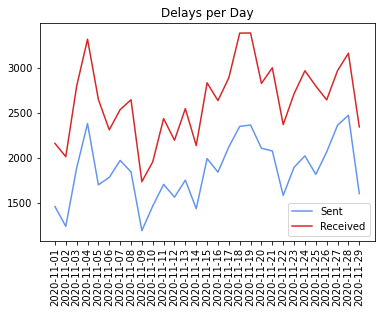

In [170]:
# Time series Graphs for Sent and received messages
# Sent
plt.plot(ts_sent,color ='cornflowerblue', label='Sent')
plt.xticks(rotation=90)
#for i in range(1000,max(ts_sent),200):
#    plt.axhline(y=i, color='black', linestyle='--',linewidth=0.5)
plt.title("Delays per Day")

# Received
plt.plot(ts_received,color ='tab:red', label='Received')
plt.xticks(rotation=90)
#for i in range(1000,max(ts_sent),200):
#    plt.axhline(y=i, color='black', linestyle='--',linewidth=0.5)
plt.title("Delays per Day")

plt.legend(loc='best')

Text(0.5, 1.0, 'Seasonality')

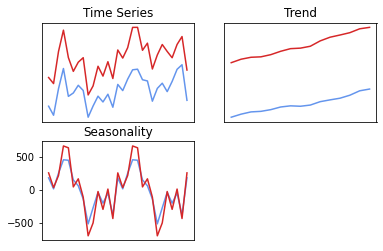

In [171]:
# Time Series TREND, SEASONAL and RANDOM for Sent and Received messages

# Creating the decomposition variable
decomp_sent = seasonal_decompose(ts_sent, period=14) # Periods can be thought of as special cases of intervals
decomp_received = seasonal_decompose(ts_received, period=14)

# Trend
tend_sent = decomp_sent.trend
tend_received = decomp_received.trend
# Seasonal
seas_sent = decomp_sent.seasonal
seas_received = decomp_received.seasonal
# Random
rand_sent = decomp_sent.resid
rand_received = decomp_received.resid

plt.figure(1)
plt.subplot(2,2,1)
plt.plot(ts_sent,color ='cornflowerblue', label='Sent')
plt.plot(ts_received,color ='tab:red',label='Received')
plt.title('Time Series')
plt.xticks([])
plt.yticks([])
plt.subplot(2,2,2)
plt.plot(tend_sent,color ='cornflowerblue')
plt.plot(tend_received,color ='tab:red')
plt.xticks([])
plt.yticks([])
plt.title('Trend')
plt.subplot(2,2,3)
plt.plot(seas_sent,color ='cornflowerblue')
plt.plot(seas_received,color ='tab:red')
plt.xticks([])
#plt.yticks([])
plt.title('Seasonality')
#plt.subplot(2,2,4)
#plt.plot(rand_sent,color ='cornflowerblue')
#plt.plot(rand_received,color ='tab:red')
#plt.xticks([])
#plt.yticks([])
#plt.title('Resid')

In [172]:
# Filter Part II

# Sent
# 3) Filter messages with macros 1001, 1002 and 1003
df_sent = df_sent.loc[(df_sent['HM_NUM_MSG']==1001)|(df_sent['HM_NUM_MSG']==1002)|(df_sent['HM_NUM_MSG']==1003)]
# 4) Filter messages that took longer than 5 minutes
df_sent = df_sent.loc[(df_sent['HM_DAT_OBC']-df_sent['HM_DAT_STC']) >= a]
# 5) Order the dataframe by HM_ID_HM
df_sent.sort_values(by=['HM_ID_HM'])

#Received
# 5) Filter messages with macros 2006, 2011, 2012, 2015, 2017, 2020, 2021 and 2029
df_received = df_received.loc[(df_received['HM_NUM_MSG']==2006)|(df_received['HM_NUM_MSG']==2011)|(df_received['HM_NUM_MSG']==2012)|(df_received['HM_NUM_MSG']==2015)|(df_received['HM_NUM_MSG']==2017)|(df_received['HM_NUM_MSG']==2020)|(df_received['HM_NUM_MSG']==2021)|(df_received['HM_NUM_MSG']==2029)]
# 6) Filter messages that took longer than 5 minutes
df_received = df_received.loc[(df_received['HM_DAT_STC']-df_received['HM_DAT_OBC']) >= a]
# 7) Order the dataframe by HM_ID_HM
df_received.sort_values(by=['HM_ID_HM'])
# 8) Remove messages that don't contain data
df_received = df_received.loc[df_received['HM_TXT_MSG'].notnull()]

df_sent.shape, df_received.shape

((318, 13), (1044, 13))

In [173]:
# Store and return the amount of messages after filtering

# Sent
totalSentMessageDelay = len(df_sent['HM_ID_HM'])

# Received
totalReceivedMessageDelay = len(df_received['HM_ID_HM'])

totalSentMessageDelay, totalReceivedMessageDelay

(318, 1044)

In [174]:
# Return the average delivery time of Sent and Received messages with delay (longer than 5 min.)

# Sent
df_sent['DELIVERY_TIME'] = df_sent['HM_DAT_OBC']-df_sent['HM_DAT_STC']
df_sent['DELIVERY_TIME'] = df_sent['DELIVERY_TIME']/np.timedelta64(1, 's')
totalSentDelay = sum(df_sent.iloc[:,11])
averageSentDeliveryDelay = round(totalSentDelay/totalSentMessageDelay,0)
# Converting from float to mm:ss
averageSentDeliveryDelay = timedelta(seconds=averageSentDeliveryDelay)
averageSentDeliveryDelay=str(averageSentDeliveryDelay)

# Received
df_received['DELIVERY_TIME'] = df_received['HM_DAT_STC']-df_received['HM_DAT_OBC']
df_received['DELIVERY_TIME'] = df_received['DELIVERY_TIME']/np.timedelta64(1, 's')
totalReceivedDelay = sum(df_received.iloc[:,11])
averageReceivedDeliveryDelay = round(totalReceivedDelay/totalReceivedMessageDelay,0)
# Converting from float to mm:ss
averageReceivedDeliveryDelay = timedelta(seconds=averageReceivedDeliveryDelay)
averageReceivedDeliveryDelay=str(averageReceivedDeliveryDelay)

averageSentDeliveryDelay, averageReceivedDeliveryDelay

('0:16:57', '0:12:33')

In [175]:
# Return the average delivery time of Sent and Received messages with delay (longer than 5 min.) combined
averageDeliveryDelay = round((totalSentDelay+totalReceivedDelay)/(totalSentMessageDelay+totalReceivedMessageDelay),0)
# Converting from float to mm:ss
averageDeliveryDelay = timedelta(seconds=averageDeliveryDelay)
averageDeliveryDelay = str(averageDeliveryDelay)

averageDeliveryDelay

'0:13:35'

In [176]:
# Adding new columns to dataframe df_sb

for i in range(0,len(df_sb['NAME']),1):
    df_sb['SECTION_DEBUT'] = "Section Début: " + df_sb.loc[:,'NAME'] + " "
    df_sb['CANTON'] = "Canton: " + df_sb.loc[:,'NAME'] + " "
    df_sb['SECTION_TETE'] = "Section da Tête: " + df_sb.loc[:,'NAME'] + " "

df_sb['COUNTS_SENT'] = 0
df_sb['COUNTS_RECEIVED'] = 0
df_sb['COUNTS_TOTAL'] = 0
df_sb['TOTAL_TIME_SENT'] = 0.0
df_sb['TOTAL_TIME_RECEIVED'] = 0.0
df_sb['TOTAL_TIME'] = 0.0
df_sb['AVERAGE_TIME_SENT'] = 0.0
df_sb['AVERAGE_TIME_RECEIVED'] = 0.0
df_sb['AVERAGE_TIME'] = 0.0
df_sb['%_SENT'] = 0
df_sb['%_RECEIVED'] = 0
df_sb['%_TOTAL'] = 0

In [177]:
# Total of delays per SB and total delivery time per SB for Sent and Received messages

# Sent
for i in range(0,len(df_sb['NAME']),1):
    for j in range(0,totalSentMessageDelay,1):
        if df_sent.iloc[j,3] == 1002 and df_sb.iloc[i,1] in df_sent.iloc[j,6]:
            df_sb.iloc[i,4] += 1
            df_sb.iloc[i,7] += df_sent.iloc[j,11]

        if df_sent.iloc[j,3] != 1002 and df_sb.iloc[i,2] in df_sent.iloc[j,6]:
            df_sb.iloc[i,4] +=1
            df_sb.iloc[i,7] += df_sent.iloc[j,11]

# Received
for i in range(0,len(df_sb['NAME']),1):
    for j in range(0,totalReceivedMessageDelay,1):
        if df_sb.iloc[i,1] in df_received.iloc[j,6]:
            df_sb.iloc[i,5] += 1
            df_sb.iloc[i,8] += df_received.iloc[j,11]
            
        if df_sb.iloc[i,2] in df_received.iloc[j,6]:
            df_sb.iloc[i,5] += 1
            df_sb.iloc[i,8] += df_received.iloc[j,11]
            
        if df_sb.iloc[i,3] in df_received.iloc[j,6]:
            df_sb.iloc[i,5] += 1
            df_sb.iloc[i,8] += df_received.iloc[j,11]
            
# !! There may be a slight difference between totalReceivedMessageDelay and the sum of df_sb['COUNTS'].
# This is because the script does not consider messages on switches 
# There are also some messages that have 'Canton:' but don't contain an actual location !!

# Total
for i in range(0, len(df_sb['NAME']),1):
    df_sb.iloc[i,6] = df_sb.iloc[i,4] + df_sb.iloc[i,5]
    df_sb.iloc[i,9] = df_sb.iloc[i,7] + df_sb.iloc[i,8]

In [178]:
# Fix for Received Messages Count
x=0
for i in range(0,len(df_sb['NAME']),1):
    x = x + df_sb.iloc[i,5]
    
# A new value is returned to 'totalReceivedMessageDelay' to correctly count the % column.
# Please refer to the difference in the comments of the previous section. (Between '!!...!!')
totalReceivedMessageDelay = x
totalReceivedMessageDelay

1014

In [179]:
# Calculate the average delay per SB

# Sent
for i in range(0,len(df_sb['NAME']),1):
    if df_sb.iloc[i,4] != 0:
        df_sb.iloc[i,10] = df_sb.iloc[i,7]/df_sb.iloc[i,4]
        df_sb.iloc[i,10] = round(df_sb.iloc[i,10],0)    # Have to round the values to Integer to avoid having milliseconds
        df_sb.iloc[i,10] = str(timedelta(seconds=df_sb.iloc[i,10])) # Converting to String time format
        df_sb.iloc[i,7] = str(timedelta(seconds=df_sb.iloc[i,7]))
    else:
        df_sb.iloc[i,10] = 0      
        df_sb.iloc[i,10] = str(timedelta(seconds=df_sb.iloc[i,10]))
        df_sb.iloc[i,7] = str(timedelta(seconds=df_sb.iloc[i,7]))
        
# Received
for i in range(0,len(df_sb['NAME']),1):
    if df_sb.iloc[i,5] != 0:
        df_sb.iloc[i,11] = df_sb.iloc[i,8]/df_sb.iloc[i,5]
        df_sb.iloc[i,11] = round(df_sb.iloc[i,11],0)    # Have to round the values to Integer to avoid having milliseconds
        df_sb.iloc[i,11] = str(timedelta(seconds=df_sb.iloc[i,11])) # Converting to String time format
        df_sb.iloc[i,8] = str(timedelta(seconds=df_sb.iloc[i,8]))
    else:
        df_sb.iloc[i,11] = 0      
        df_sb.iloc[i,11] = str(timedelta(seconds=df_sb.iloc[i,11]))
        df_sb.iloc[i,8] = str(timedelta(seconds=df_sb.iloc[i,8]))
        
# Total
for i in range(0,len(df_sb['NAME']),1):
    if df_sb.iloc[i,6] != 0:
        df_sb.iloc[i,12] = df_sb.iloc[i,9]/df_sb.iloc[i,6]
        df_sb.iloc[i,12] = round(df_sb.iloc[i,12],0)    # Have to round the values to Integer to avoid having milliseconds
        df_sb.iloc[i,12] = str(timedelta(seconds=df_sb.iloc[i,12])) # Converting to String time format
        df_sb.iloc[i,9] = str(timedelta(seconds=df_sb.iloc[i,9]))
    else:
        df_sb.iloc[i,12] = 0      
        df_sb.iloc[i,12] = str(timedelta(seconds=df_sb.iloc[i,12]))
        df_sb.iloc[i,9] = str(timedelta(seconds=df_sb.iloc[i,9]))

In [180]:
# Calculate the % of total delays per SB

# Sent
for i in range(0,len(df_sb['NAME']),1):
    df_sb.iloc[i,13] = round((df_sb.iloc[i,4]/totalSentMessageDelay)*100,2)
    df_sb.iloc[i,13] = str(df_sb.iloc[i,13])+'%'
    
# Received
for i in range(0,len(df_sb['NAME']),1):
    df_sb.iloc[i,14] = round((df_sb.iloc[i,5]/totalReceivedMessageDelay)*100,2)
    df_sb.iloc[i,14] = str(df_sb.iloc[i,14])+'%'
    
# Total
for i in range(0,len(df_sb['NAME']),1):
    df_sb.iloc[i,15] = round((df_sb.iloc[i,6]/(totalSentMessageDelay+totalReceivedMessageDelay))*100,2)
    df_sb.iloc[i,15] = str(df_sb.iloc[i,15])+'%'

Text(0.5, 1.0, 'All Messages')

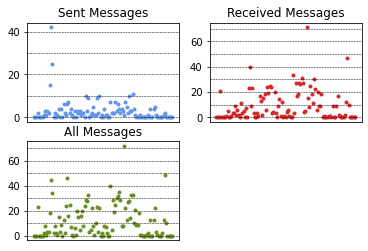

In [181]:
# Dispersion graph that represents all SBs em dots en shows the number of delays
plt.figure(1)
plt.subplot(2,2,1)
plt.scatter(df_sb.iloc[:,0],df_sb.iloc[:,4], color='cornflowerblue', marker='.')
plt.xticks([])
for i in range(0,max(df_sb.iloc[:,4]),10):
    plt.axhline(y=i, color='black', linestyle='--',linewidth=0.5)
plt.title("Sent Messages")
plt.subplot(2,2,2)
plt.scatter(df_sb.iloc[:,0],df_sb.iloc[:,5], color='tab:red', marker='.')
plt.xticks([])
for i in range(0,max(df_sb.iloc[:,5]),10):
    plt.axhline(y=i, color='black', linestyle='--',linewidth=0.5)
plt.title("Received Messages") 
plt.subplot(2,2,3)
plt.scatter(df_sb.iloc[:,0],df_sb.iloc[:,6], color='olivedrab', marker='.')
plt.xticks([])
for i in range(0,max(df_sb.iloc[:,6]),10):
    plt.axhline(y=i, color='black', linestyle='--',linewidth=0.5)
plt.title("All Messages")    

Text(0.5, 1.0, 'Delivery of >5 min. per Section Block')

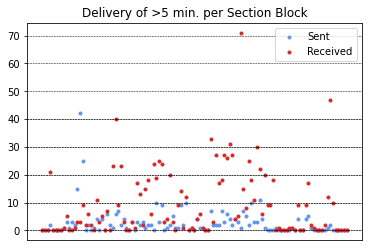

In [182]:
# Another dispersion graph, this time as one graph
plt.scatter(df_sb.iloc[:,0],df_sb.iloc[:,4], color='cornflowerblue', marker='.', label='Sent')
plt.xticks([])
for i in range(0,max(df_sb.iloc[:,4]),10):
    plt.axhline(y=i, color='black', linestyle='--',linewidth=0.5)
    
plt.scatter(df_sb.iloc[:,0],df_sb.iloc[:,5], color='tab:red', marker='.', label='Received')
plt.xticks([])
for i in range(0,max(df_sb.iloc[:,5]),10):
    plt.axhline(y=i, color='black', linestyle='--',linewidth=0.5)
plt.legend(loc='best')
plt.title("Delivery of >5 min. per Section Block")

Text(0.5, 1.0, 'Delivery of >5 min. per Section Block')

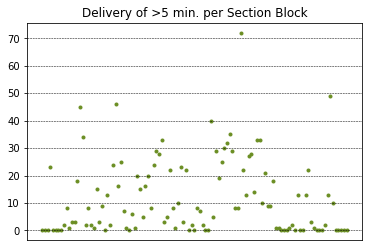

In [183]:
# Dispersion graph of SENT and RECEIVED messages (TOTAL) combined
plt.scatter(df_sb.iloc[:,0],df_sb.iloc[:,6], color='olivedrab', marker='.')
plt.xticks([])
for i in range(0,max(df_sb.iloc[:,6]),10):
    plt.axhline(y=i, color='black', linestyle='--',linewidth=0.5)
plt.title("Delivery of >5 min. per Section Block") 

In [184]:
# Reordering dataframe and selecting TOP 10 for barplot graph
ordered_Sent = df_sb.sort_values(by=['COUNTS_SENT'], ascending=False)
ordered_Received = df_sb.sort_values(by=['COUNTS_RECEIVED'], ascending=False)
ordered_Total = df_sb.sort_values(by=['COUNTS_TOTAL'], ascending=False)

top10_Sent = ordered_Sent.head(n=10)
top10_Received = ordered_Received.head(n=10)
top10_Total = ordered_Total.head(n=10)

top10_Sent = top10_Sent.sort_values(by=['COUNTS_SENT'], ascending=True)
top10_Received = top10_Received.sort_values(by=['COUNTS_RECEIVED'], ascending=True)
top10_Total = top10_Total.sort_values(by=['COUNTS_TOTAL'], ascending=True)

Text(0.5, 1.0, 'All Messages')

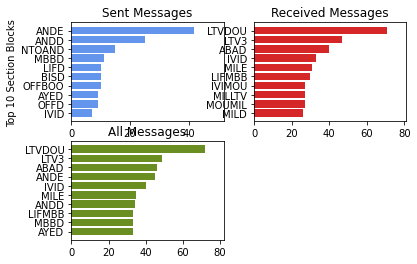

In [185]:
# Horizontal Barplot 
plt.figure(1)
plt.subplot(2,2,1)
plt.barh(top10_Sent.iloc[:,0],top10_Sent.iloc[:,4], color ='cornflowerblue',align='center')
plt.xlim(0,max(df_sb.iloc[:,4])+10)
plt.xlabel("Number of messages") 
plt.ylabel("Top 10 Section Blocks")
plt.title("Sent Messages") 
# Adding percentage values of '%' column to the bars
#for index, value in enumerate(top10_Sent.iloc[:,4]):
#    plt.text(value, index, str(top10_Sent.iloc[index,13]))
plt.subplot(2,2,2)
plt.barh(top10_Received.iloc[:,0],top10_Received.iloc[:,5], color ='tab:red',align='center')
plt.xlim(0,max(df_sb.iloc[:,5])+10)
plt.title("Received Messages")
plt.subplot(2,2,3)
plt.barh(top10_Total.iloc[:,0],top10_Total.iloc[:,6], color ='olivedrab',align='center')
plt.xlim(0,max(df_sb.iloc[:,6])+10)
plt.title("All Messages") 

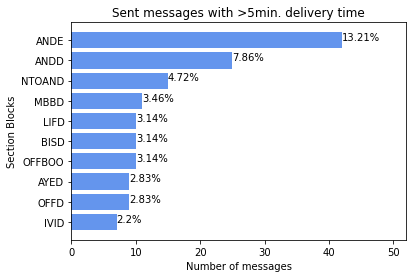

In [186]:
# Horizontal Barplot for Sent Messages
plt.barh(top10_Sent.iloc[:,0],top10_Sent.iloc[:,4], color ='cornflowerblue',align='center')
plt.xlim(0,max(df_sb.iloc[:,4])+10)
plt.xlabel("Number of messages") 
plt.ylabel("Section Blocks")
plt.title("Sent messages with >5min. delivery time") 
# Adding percentage values of '%' column to the bars
for index, value in enumerate(top10_Sent.iloc[:,4]):
    plt.text(value, index, str(top10_Sent.iloc[index,13]))

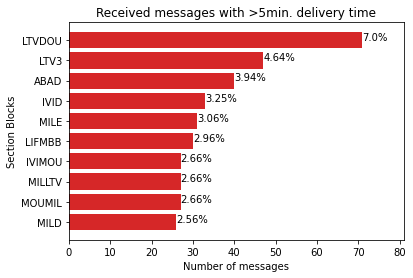

In [187]:
# Horizontal Barplot for Received Messages
plt.barh(top10_Received.iloc[:,0],top10_Received.iloc[:,5], color ='tab:red',align='center')
plt.xlim(0,max(df_sb.iloc[:,5])+10)
plt.xlabel("Number of messages") 
plt.ylabel("Section Blocks")
plt.title("Received messages with >5min. delivery time") 
# Adding percentage values of '%' column to the bars
for index, value in enumerate(top10_Received.iloc[:,5]):
    plt.text(value, index, str(top10_Received.iloc[index,14]))

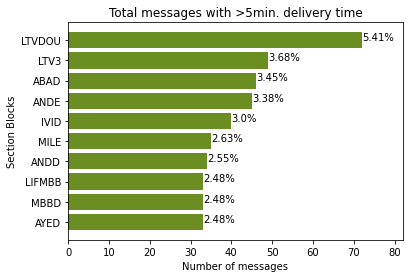

In [188]:
# Horizontal Barplot for Total Messages
plt.barh(top10_Total.iloc[:,0],top10_Total.iloc[:,6], color ='olivedrab',align='center')
plt.xlim(0,max(df_sb.iloc[:,6])+10)
plt.xlabel("Number of messages") 
plt.ylabel("Section Blocks")
plt.title("Total messages with >5min. delivery time") 
# Adding percentage values of '%' column to the bars
for index, value in enumerate(top10_Total.iloc[:,6]):
    plt.text(value, index, str(top10_Total.iloc[index,15]))